In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 12 - Psychophysical functions
  
A psychophysical function, showing the a sigmoid or S-shaped relationship between stimulus intensity and choice behavior. Important theoretical measures known as the point of subjective equality (PSE) and just noticeable difference (JND) are highlighted.

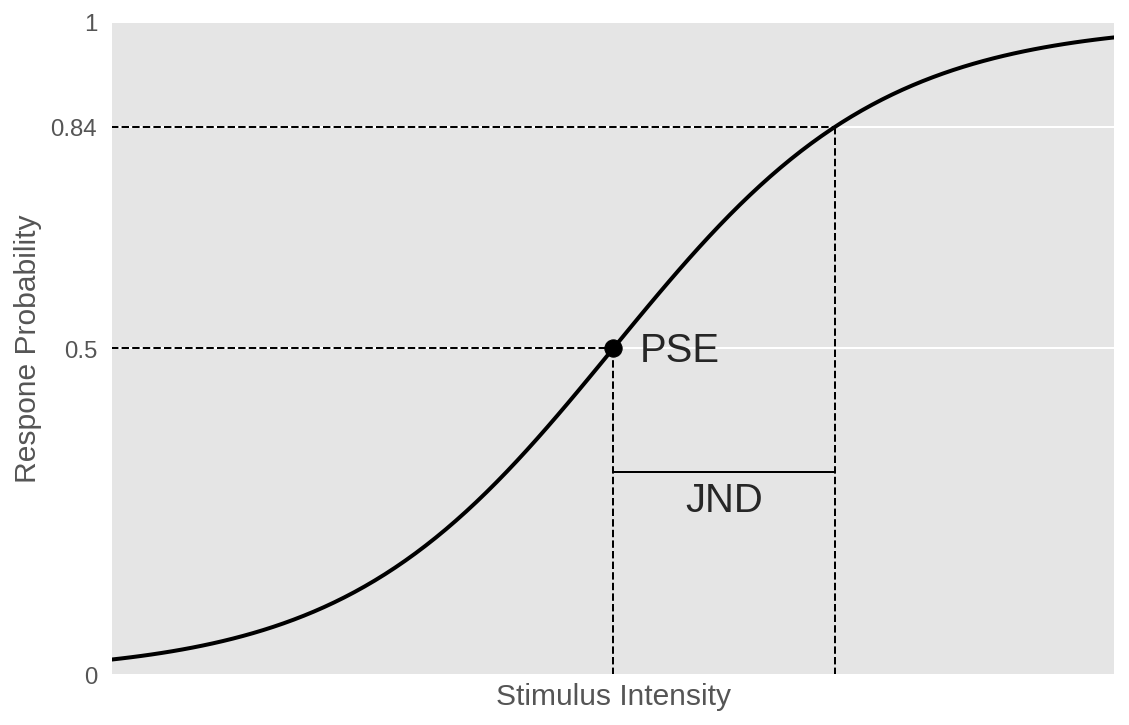

In [2]:
def logit(x):
    return 1/(1+np.exp(-x))
def invlogit(x):
    return np.log(x/(1-x))

x = np.linspace(-3.75, 3.75, 100)
fig, ax = plt.subplots(figsize=(9, 6))
x1 = invlogit(.5)
x2 = invlogit(.84)

plt.plot(x, logit(x), 'k', linewidth=2)
plt.plot([x1, x1], [0, .5], color='k', linestyle='--', linewidth=1)
plt.plot([-3.75, x1], [.5, .5], color='k', linestyle='--', linewidth=1)
plt.plot([x2, x2], [0, .84], color='k', linestyle='--', linewidth=1)
plt.plot([-3.75, x2], [.84, .84], color='k', linestyle='--', linewidth=1)

plt.scatter(x1, .5, c='k', s=75)
plt.text(x1+.5, .5-.02, "PSE", horizontalalignment='center', fontsize=20)
plt.plot([x1, x2], [.5/2+.06, .5/2+.06], color='k', linewidth=1)
plt.text((x1+x2)/2, .5/2, "JND", horizontalalignment='center', fontsize=20)

ax.set_xticks(())
ax.set_yticks((0, .5, .84, 1))
ax.set_yticklabels(('0', '0.5', '0.84', '1'), fontsize=12)
plt.xlim(-3.75, 3.75)
plt.ylim(0, 1)
plt.xlabel('Stimulus Intensity', fontsize=15)
plt.ylabel('Respone Probability', fontsize=15)
plt.show()

Data for all 8 subjects, showing the proportion of “long” responses as a function of test interval duration.

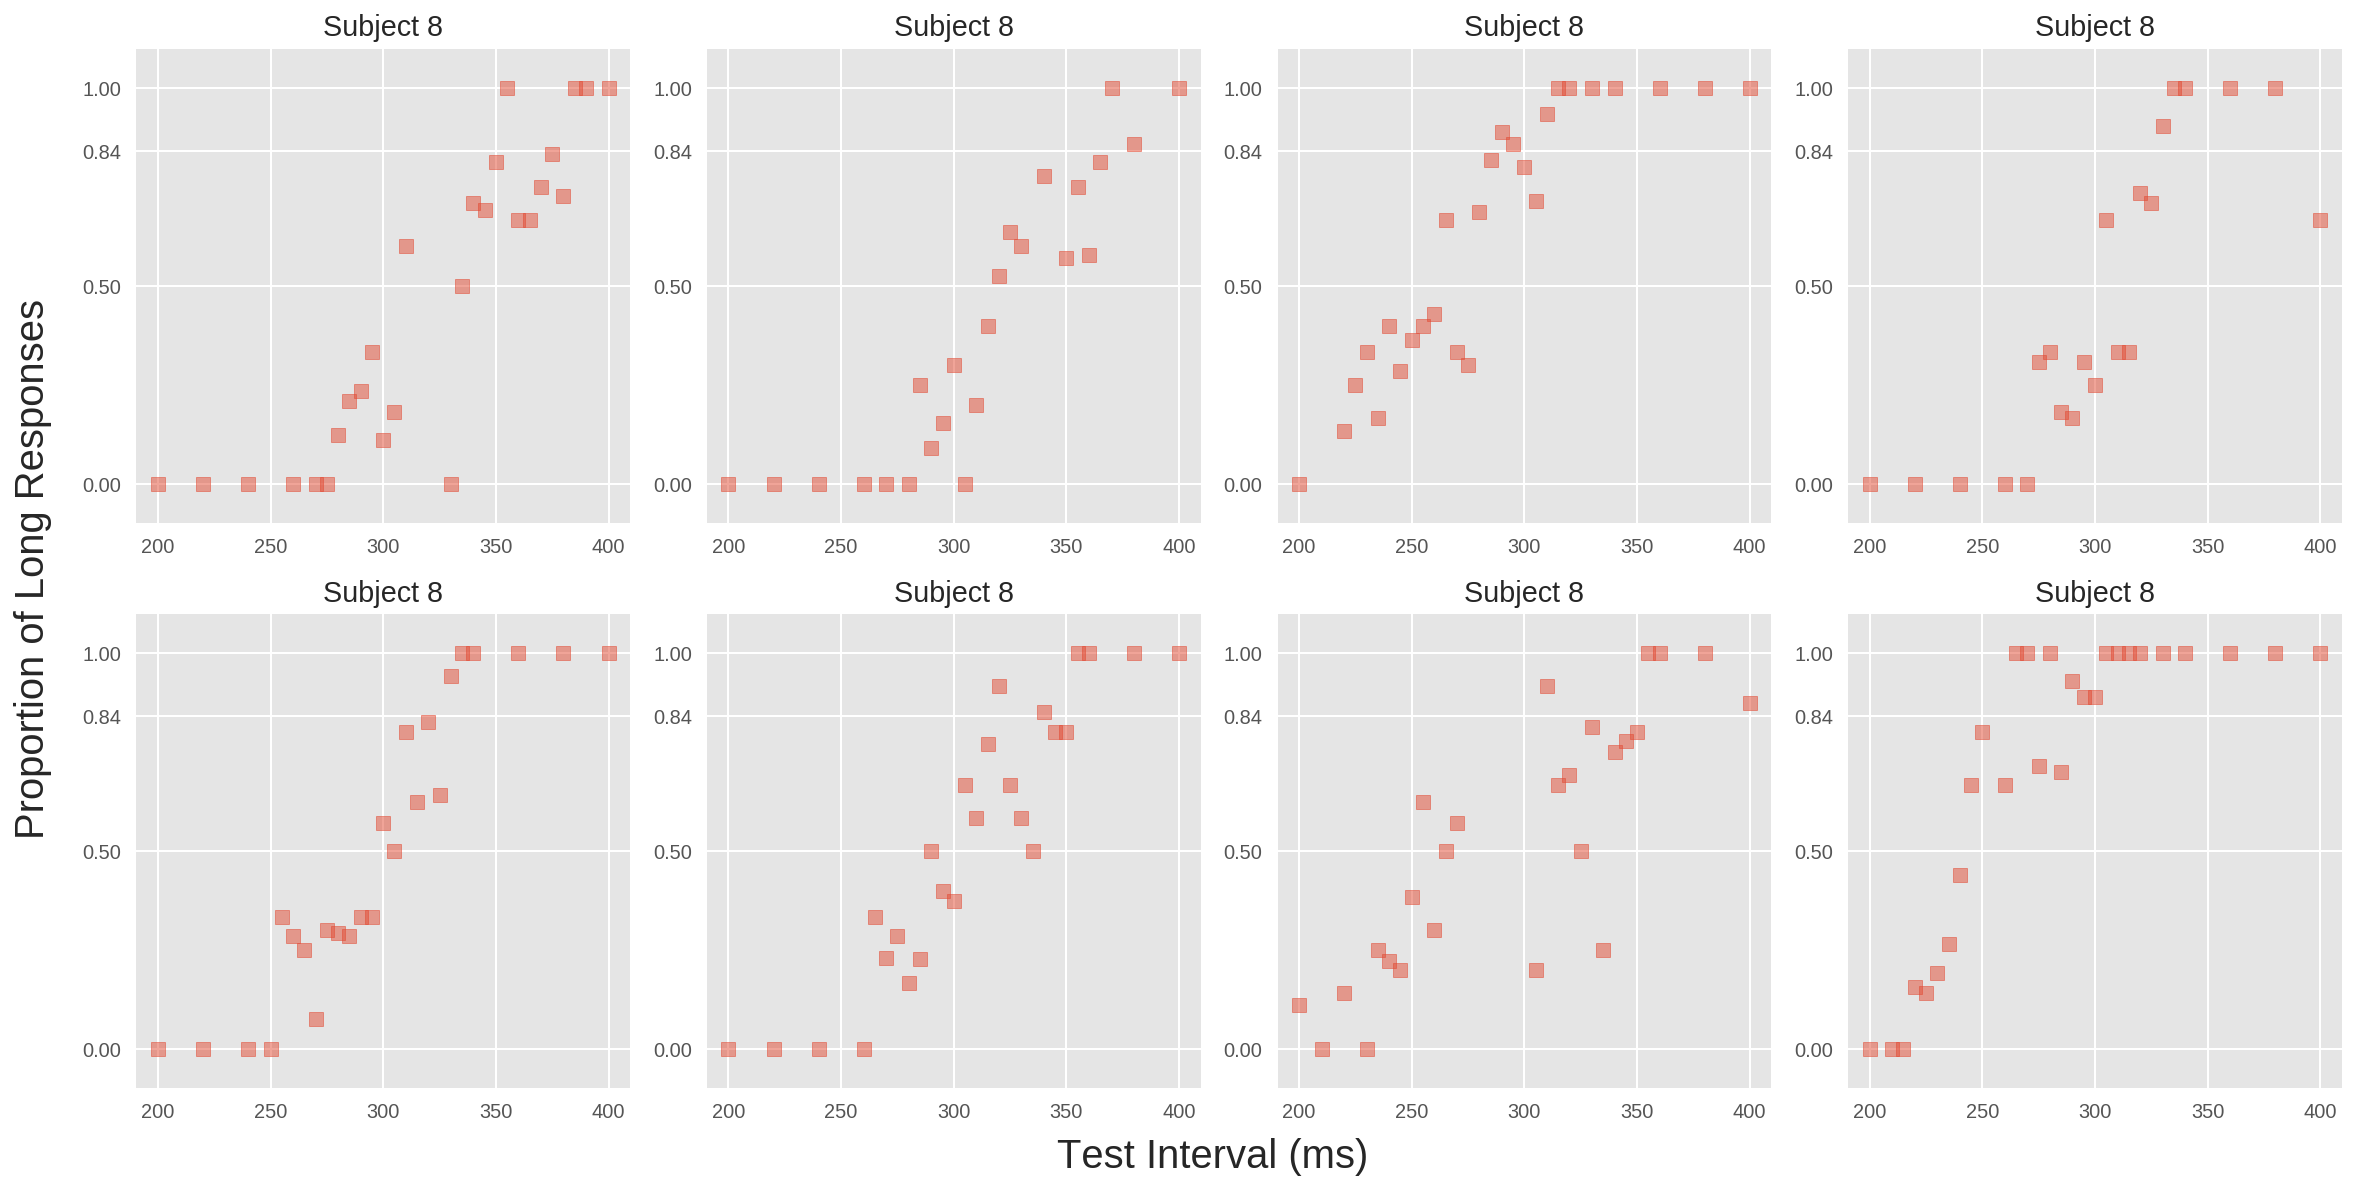

In [3]:
x = pd.read_csv("./data/data_x.txt", sep='\t', header=None)
n = pd.read_csv("./data/data_n.txt", sep='\t', header=None)
r = pd.read_csv("./data/data_r.txt", sep='\t', header=None)
rprop = pd.read_csv("./data/data_rprop.txt", sep='\t', header=None)

xmean = np.array([318.888, 311.0417, 284.4444, 301.5909, 
                  296.2000, 305.7692, 294.6429, 280.3571])
nstim = np.array([27, 24, 27, 22, 25, 26, 28, 28])
nsubjs = 8

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip, :])
    yp = np.array(rprop.iloc[ip, :])
    ax.scatter(xp, yp, marker='s', alpha=.5)
    plt.axis([190, 410, -.1, 1.1])
    plt.yticks((0, .5, .84, 1))
    plt.title('Subject %s'%(nsubjs))

plt.tight_layout()
plt.show()

The psychometric function here is a logistic function with parameters $\alpha_i$ and $\beta_i$:  

$$ \theta_{ij} = \frac{1}{1+\text{exp}\{-[\alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})]\}}$$  
$$\text{or}$$   
$$ \text{logit}(\theta_{ij}) = \alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})$$

## 12.1 Psychophysical functions


$$ r_{ij} \sim \text{Binomial}(\theta_{ij},n_{ij})$$
$$ \text{logit}(\theta_{ij}) = \alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},\sigma_{\alpha})$$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta},\sigma_{\beta})$$
$$ \mu_{\alpha} \sim \text{Gaussian}(0,0.001)$$
$$ \mu_{\beta} \sim \text{Gaussian}(0,0.001)$$
$$ \sigma_{\alpha} \sim \text{Uniform}(0,1000)$$
$$ \sigma_{\beta} \sim \text{Uniform}(0,1000)$$

In [4]:
xij_tmp = x.values
nij_tmp = n.values
rij_tmp = r.values
tmp,nstim2 = np.shape(xij_tmp)

xmeanvect = np.repeat(xmean, nstim2)
sbjidx = np.repeat(np.arange(nsubjs), nstim2)

# remove nans
validmask = np.isnan(xij_tmp.flatten())==False
xij2 = xij_tmp.flatten()
nij2 = nij_tmp.flatten()
rij2 = rij_tmp.flatten()

xij = xij2[validmask]
nij = nij2[validmask]
rij = rij2[validmask]
xvect = xmeanvect[validmask]
sbjid = sbjidx[validmask]

Helper function

In [5]:
def Phi(x):
    # probit transform 
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))
def tlogit(x):
    return 1/(1+tt.exp(-x))

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 320.16:  37%|███▋      | 73973/200000 [00:13<00:20, 6029.83it/s]
Convergence archived at 74300
Interrupted at 74,300 [37%]: Average Loss = 370.08
100%|██████████| 10500/10500.0 [00:28<00:00, 368.88it/s]


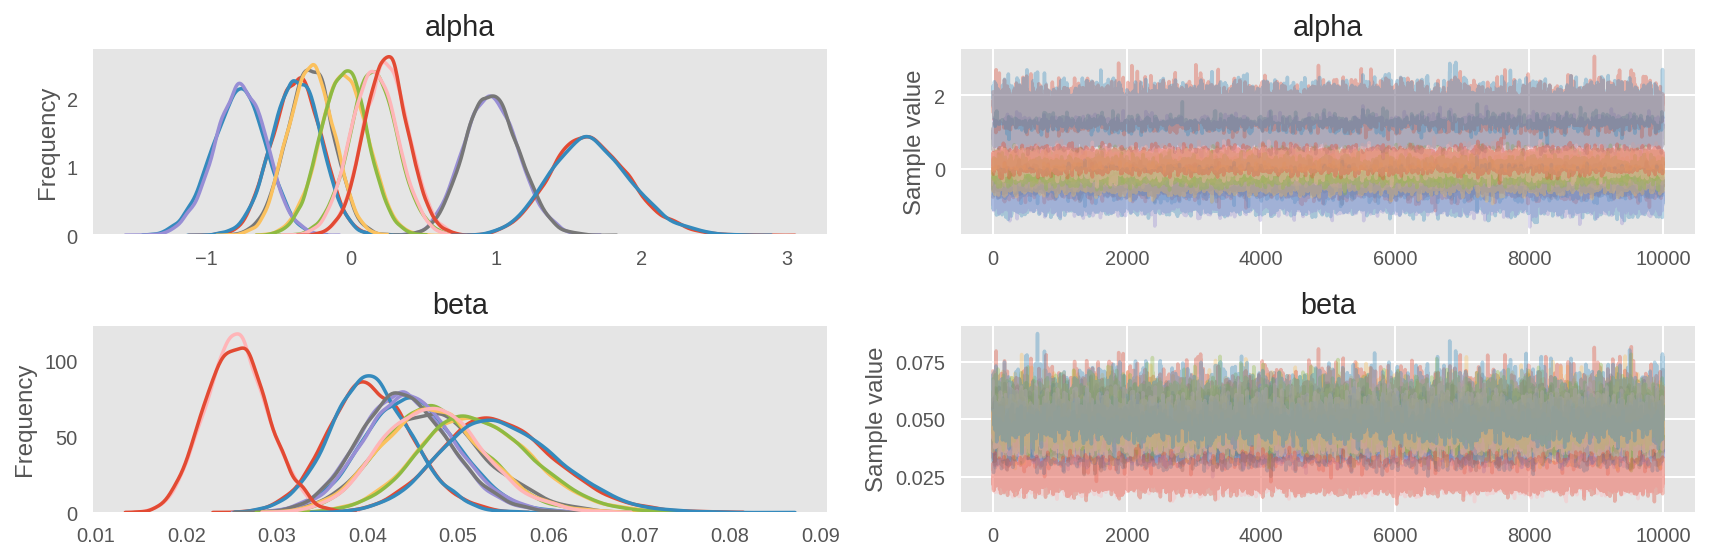

In [8]:
with pm.Model() as model1:
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=1000)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=1000)
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nsubjs)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nsubjs)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    thetaij=pm.Deterministic('thetaij', tlogit(linerpredi))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)
    trace1 = pm.sample(1e4, njobs=2, init='advi+adapt_diag')
    
pm.traceplot(trace1, varnames=['alpha', 'beta']);

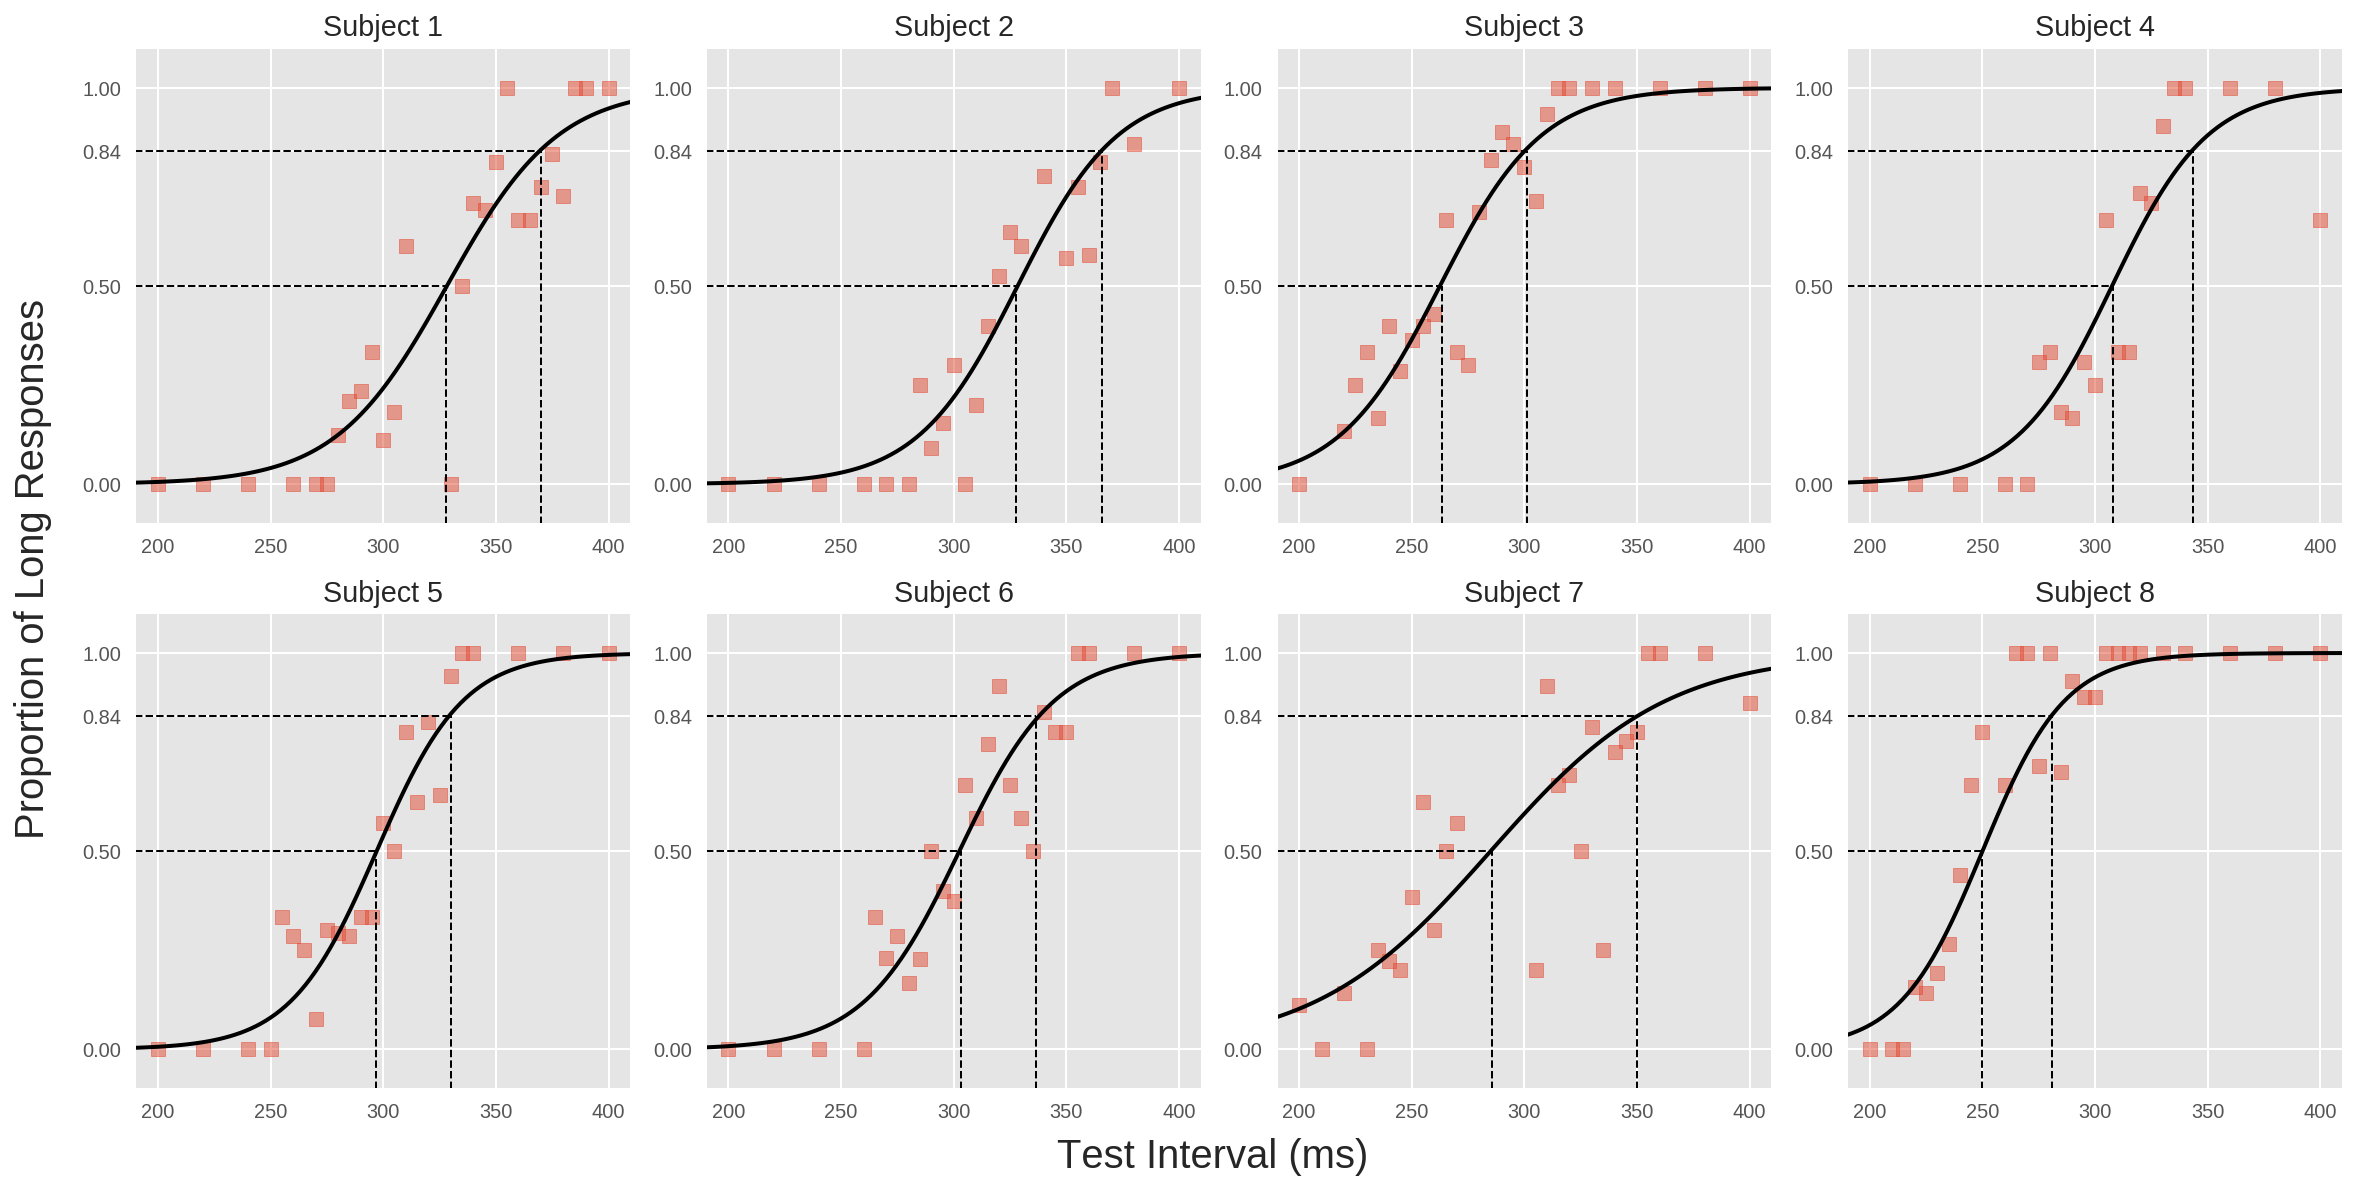

In [9]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

burnin=9000
# get MAP estimate
tmp = pm.df_summary(trace1[burnin:], varnames=['alpha', 'beta'])
alphaMAP = tmp['mean'][np.arange(nsubjs)]
betaMAP = tmp['mean'][np.arange(nsubjs)+nsubjs]

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip, :])
    yp = np.array(rprop.iloc[ip, :])
    ax.scatter(xp, yp, marker='s', alpha=.5)
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot([x1, x1],[-.1, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([190, x1],[.5, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([x2, x2],[-.1, .84], color='k', linestyle='--', linewidth=1)
    plt.plot([190, x2],[.84, .84], color='k', linestyle='--', linewidth=1)

    plt.axis([190, 410, -.1, 1.1])
    plt.yticks((0, .5, .84, 1))
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()

In [10]:
# Posterior sample
from collections import defaultdict
alphadist = model1.alpha
betadist = model1.beta

ppcsamples = 500
ppcsize = 100
ppc = defaultdict(list)
for idx in np.random.randint(burnin, 1e4, ppcsamples):
    param = trace1[idx]
    ppc['alpha'].append(alphadist.distribution.random(point=param, size=ppcsize))
    ppc['beta'].append(betadist.distribution.random(point=param, size=ppcsize))
    
# np.asarray(ppc['alpha']).shape
alphaPPC = np.asarray(ppc['alpha']).mean(axis=1)
betaPPC = np.asarray(ppc['beta']).mean(axis=1)

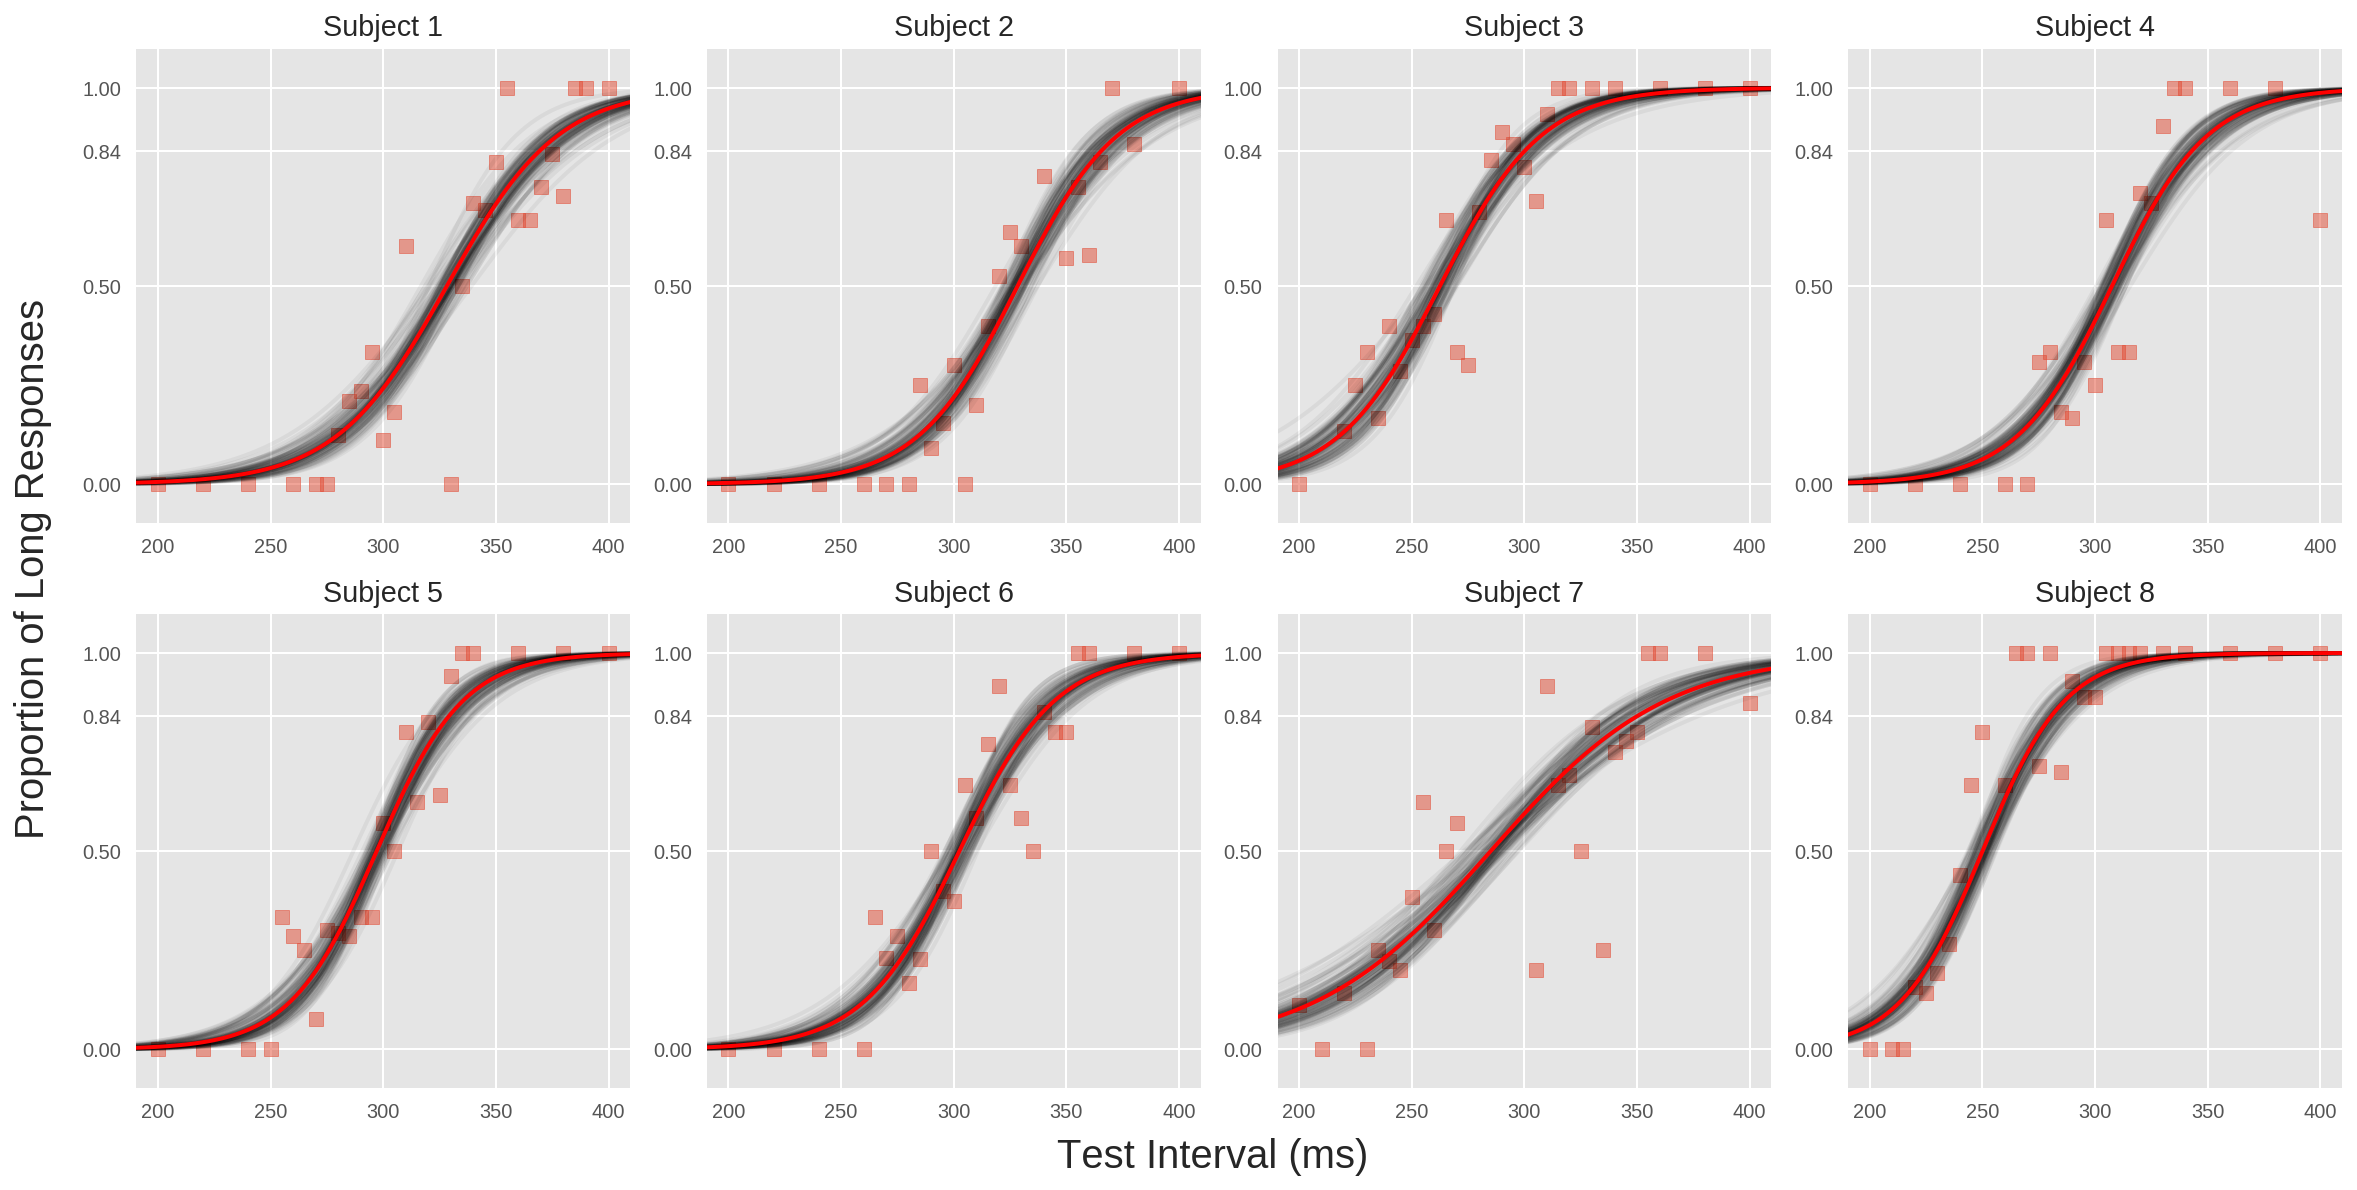

In [11]:
# PLOT FOR EXERCISE 12.1.2 
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

ppcsamples=100

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip, :])
    yp = np.array(rprop.iloc[ip, :])
    ax.scatter(xp, yp, marker='s', alpha=.5)
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))

    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 1e4, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        plt.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    plt.plot(xl, yl, 'r', linewidth=2)
    
    plt.axis([190, 410, -.1, 1.1])
    plt.yticks((0, .5, .84, 1))
    plt.title('Subject %s'%(ip+1))
    
    
plt.tight_layout()
plt.show()

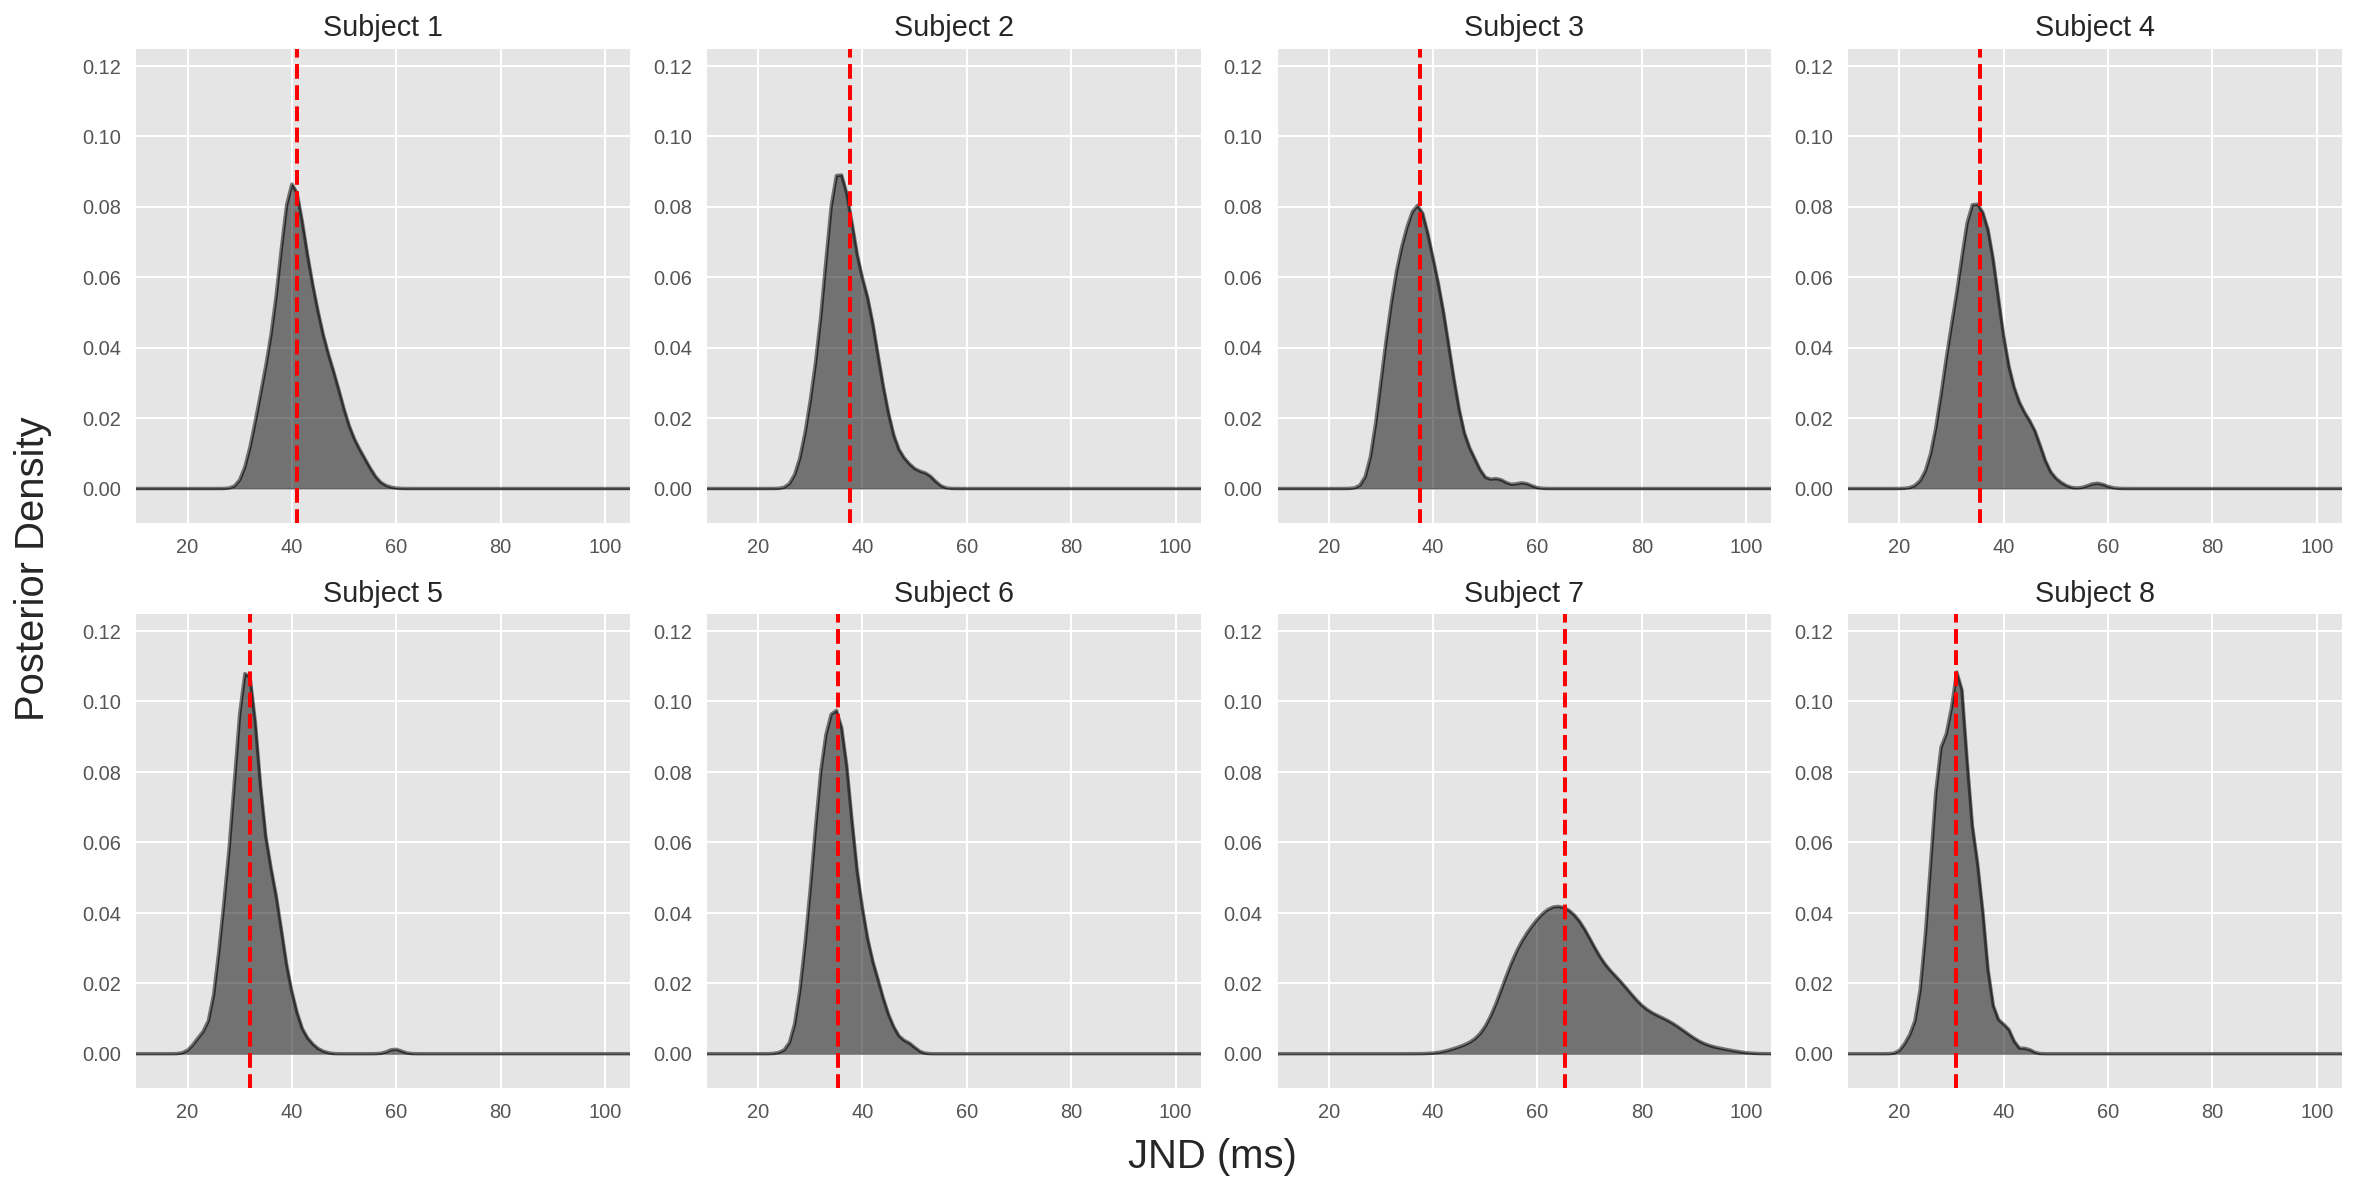

In [12]:
# PLOT FOR EXERCISE 12.1.4 
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'JND (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Posterior Density', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

ppcsamples=500

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    
    xl = np.linspace(190, 410, 200)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]
    jnd1 = x2-x1
    
    # Posterior sample
    jndps=[]
    for ips in np.random.randint(burnin, 1e4, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2, .5)]
        x2 = xl[find_nearest(yl2, .84)]
        jndps.append(x2-x1)
        
    pdfpc = gaussian_kde(jndps)
    x2=np.linspace(10, 109, 100)
    plt.plot(x2, pdfpc(x2), 'k', alpha=.5) 
    plt.fill_between(x2, pdfpc(x2), 0, alpha=.5, color='k')
    plt.axvline(jnd1, color='r', ls='--', lw=2)
    
    plt.axis([10, 105, -.01, .125])
    plt.title('Subject %s'%(ip+1))
    
    
plt.tight_layout()
plt.show()

## 12.2 Psychophysical functions under contamination

Latent-mixture model approach  
$$ r_{ij} \sim \text{Binomial}(\theta_{ij},n_{ij})$$

$$   \theta_{ij} \sim
\begin{cases}
\frac{1}{1+\text{exp}\{-[\alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})]\}}  & \text{if $z_{ij} = 0$} \\
\pi_{ij}  & \text{if $z_{ij} = 1$}
\end{cases}  $$

$$ \Phi^{-1}(\phi_{i}) \sim \text{Gaussian}(\mu_{\phi},\sigma_{\phi})$$
$$ z_{ij} \sim \text{Bernoulli}(\phi_{i})$$
$$ \pi_{ij} \sim \text{Uniform}(0,1)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},\sigma_{\alpha})$$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta},\sigma_{\beta})$$
$$ \mu_{\alpha},\mu_{\beta},\mu_{\phi} \sim \text{Gaussian}(0,0.001)$$
$$ \sigma_{\alpha},\sigma_{\beta} \sim \text{Uniform}(0,1000)$$
$$ \sigma_{\phi} \sim \text{Uniform}(0,3)$$

NOTICE: In the model following I set the prior of $\sigma$ to $ \sigma_{\alpha},\sigma_{\beta},\sigma_{\phi} \sim \text{Uniform}(0,3)$. Otherwise the model does not converge to the desired parameters.

In [13]:
with pm.Model() as model2b:
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=3)# change here so that the sampling is faster
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=3)# 
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nsubjs)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nsubjs)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    
    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=nsubjs, testval=np.ones(nsubjs))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=xij.shape)
    
    # reparameterized so we can use ADVI initialization
    # zij_ = pm.Uniform('zij_',lower=0, upper=1, shape=xij.shape)
    # zij = pm.Deterministic('zij', tt.lt(zij_, phii[sbjid]))
    
    # rng = tt.shared_randomstreams.RandomStreams()
    # zij_ = rng.binomial(n=1, p=phii[sbjid], size=xij.shape)
    zij_ = pm.theanof.tt_rng().uniform(size=xij.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[sbjid]))
    # zij = pm.Deterministic('zij', tt.eq(zij_, 0))
    
    thetaij = pm.Deterministic('thetaij', tt.switch(zij, tlogit(linerpredi), pi_ij))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)

Average Loss = inf: 100%|██████████| 20000/20000 [00:05<00:00, 3535.07it/s]
Finished [100%]: Average Loss = 601.2
Average Loss = 468.89: 100%|██████████| 10000/10000 [00:02<00:00, 3586.39it/s]
Finished [100%]: Average Loss = 468.93


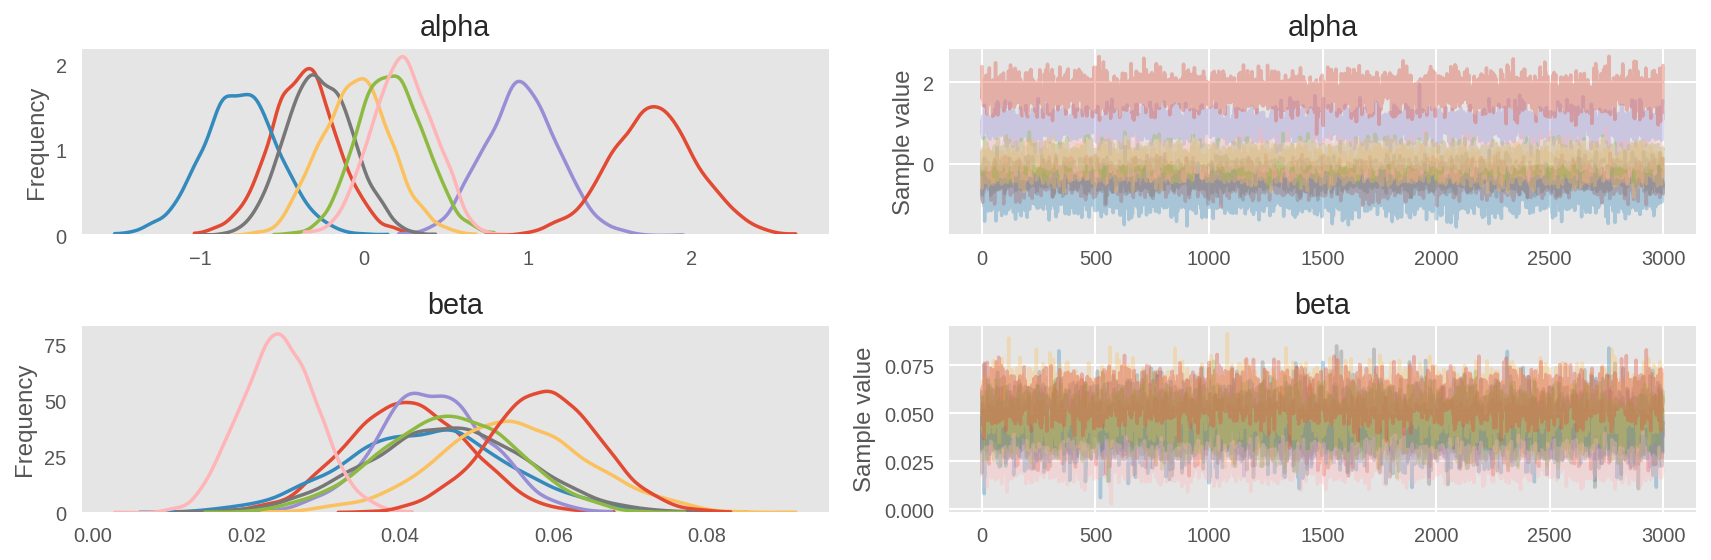

In [14]:
import theano
with model2b:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace2b = approx.sample(3000, include_transformed=True) 
    elbos1 = -inference.hist
    
pm.traceplot(trace2b, varnames=['alpha', 'beta']);

Now used the ADVI result from above to initialize our original model without reparameterization of $z_{ij}$

In [20]:
njob = 1
start = trace2b[0]
start['zij'] = start['zij'].astype(int)
stds = approx.gbij.rmap(approx.std.eval())
cov = model2b.dict_to_array(stds) ** 2
with pm.Model() as model2b_:
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=3)# change here so that the sampling is faster
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=3)# 
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nsubjs)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nsubjs)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    
    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=nsubjs, testval=np.ones(nsubjs))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=xij.shape)
    
    # place holder if zij_ is in the graph in the previous model
    #zij_ = pm.Uniform('zij_',lower=0, upper=1, shape=xij.shape)
    
    zij = pm.Bernoulli('zij', p=phii[sbjid], shape=xij.shape)
    thetaij = pm.Deterministic('thetaij', tt.switch(tt.eq(zij, 0), tlogit(linerpredi), pi_ij))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)
    
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace2b_ = pm.sample(3e3, step=step, start=start, njobs=njob)

Assigned BinaryGibbsMetropolis to zij
100%|██████████| 3500/3500.0 [02:02<00:00, 29.22it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 35 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



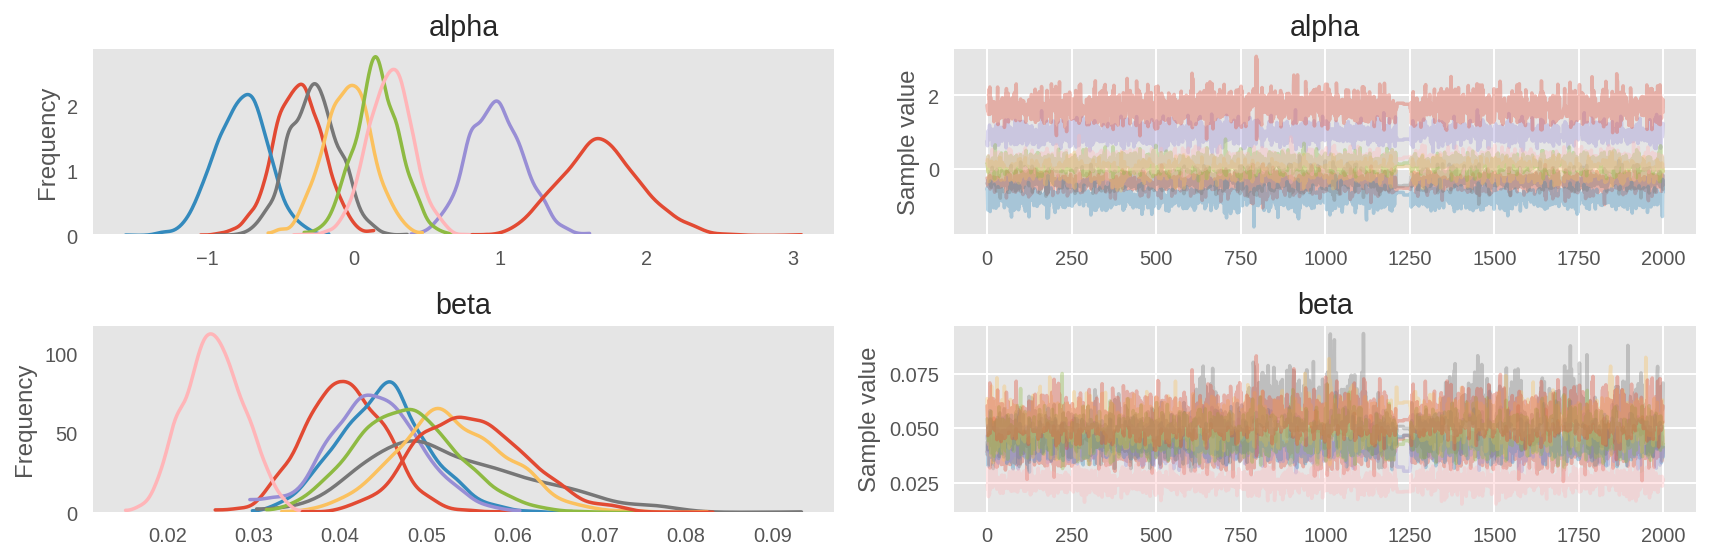

In [21]:
pm.traceplot(trace2b_[1000:], varnames=['alpha', 'beta']);

Psychophysical functions corresponding to expected posterior parameter values, using the model including a contaminant process, for each of the 8 subjects. Square markers representing data are colored to represent how certain they are to be generated by the psychophysical process (lighter) or the contaminant process (darker).

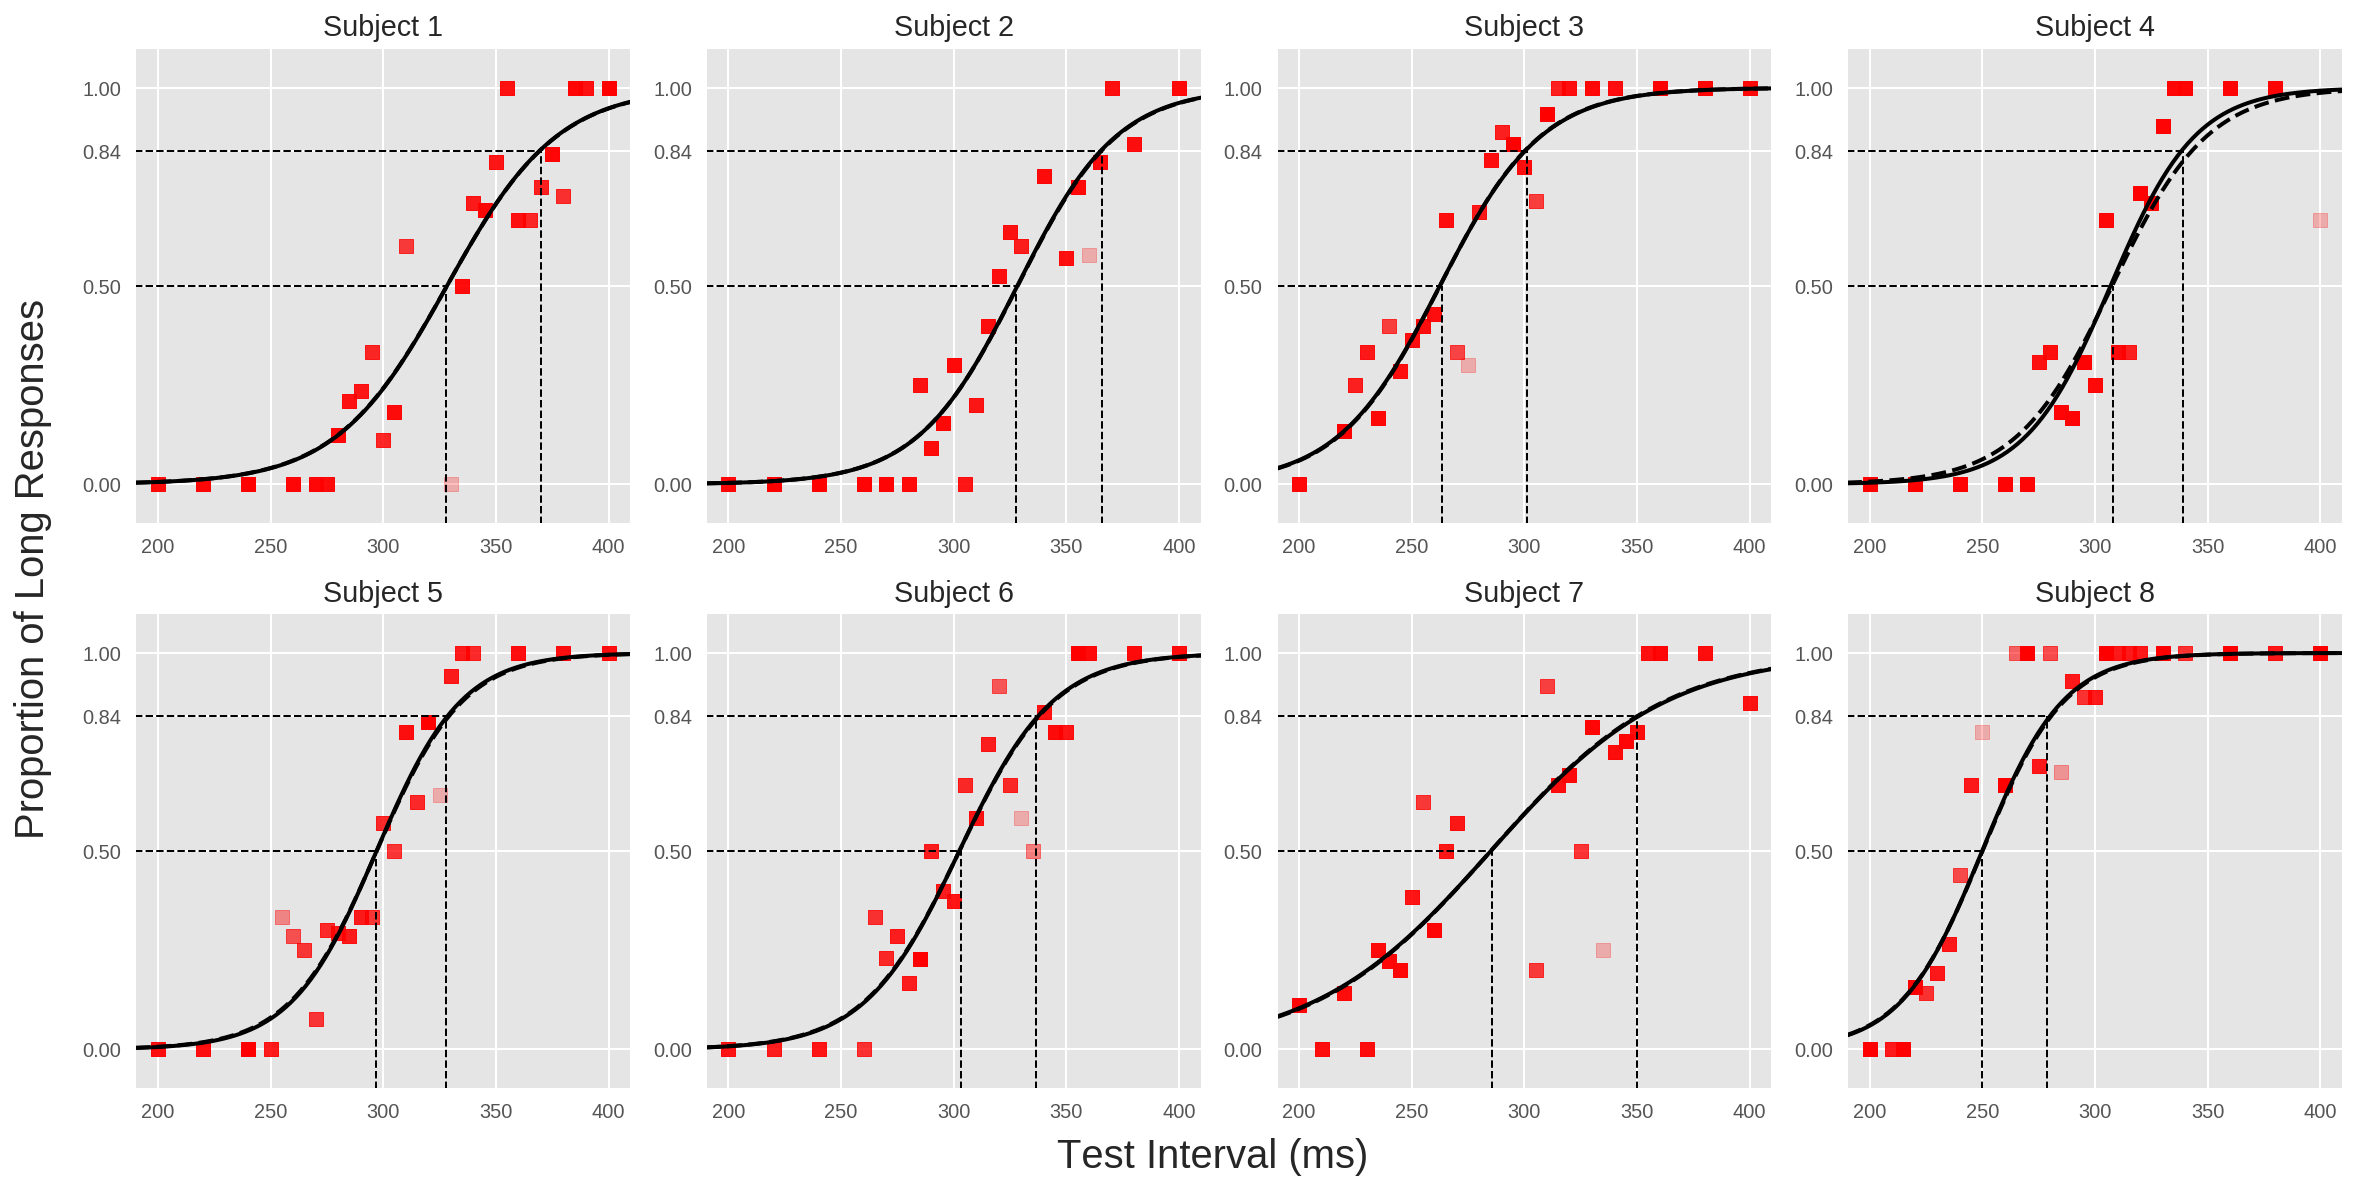

In [22]:
# reproduce figure 12.6
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

trace2 = trace2b_
burnin = 1000
# get MAP estimate
tmp = pm.df_summary(trace2[burnin:], varnames=['alpha', 'beta'])
tmp2 = pm.df_summary(trace2[burnin:], varnames=['zij'])

alphaMAP2 = tmp['mean'][np.arange(nsubjs)]
betaMAP2 = tmp['mean'][np.arange(nsubjs)+nsubjs]

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip, :])
    yp = np.array(rprop.iloc[ip, :])
    v1 = np.asarray(tmp2['mean'][sbjid==ip])
    rgbclr = np.zeros((len(v1),4))
    rgbclr[:,0] = 1
    # scale the alpha here - lighter color indicates less weight in the model (i.e., outliner)
    rgbclr[:,3] = 1 - v1/v1.max()*.75
    ax.scatter(xp, yp, marker='s', color=rgbclr)
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP2[ip] + betaMAP2[ip]*(xl-xmean[ip]))
    yl2= logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot(xl, yl2, 'k', linestyle='--', linewidth=2)
    plt.plot([x1, x1], [-.1, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([190, x1], [.5, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([x2, x2], [-.1, .84], color='k', linestyle='--', linewidth=1)
    plt.plot([190, x2], [.84, .84], color='k', linestyle='--', linewidth=1)

    plt.axis([190, 410, -.1, 1.1])
    plt.yticks((0, .5, .84, 1))
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()

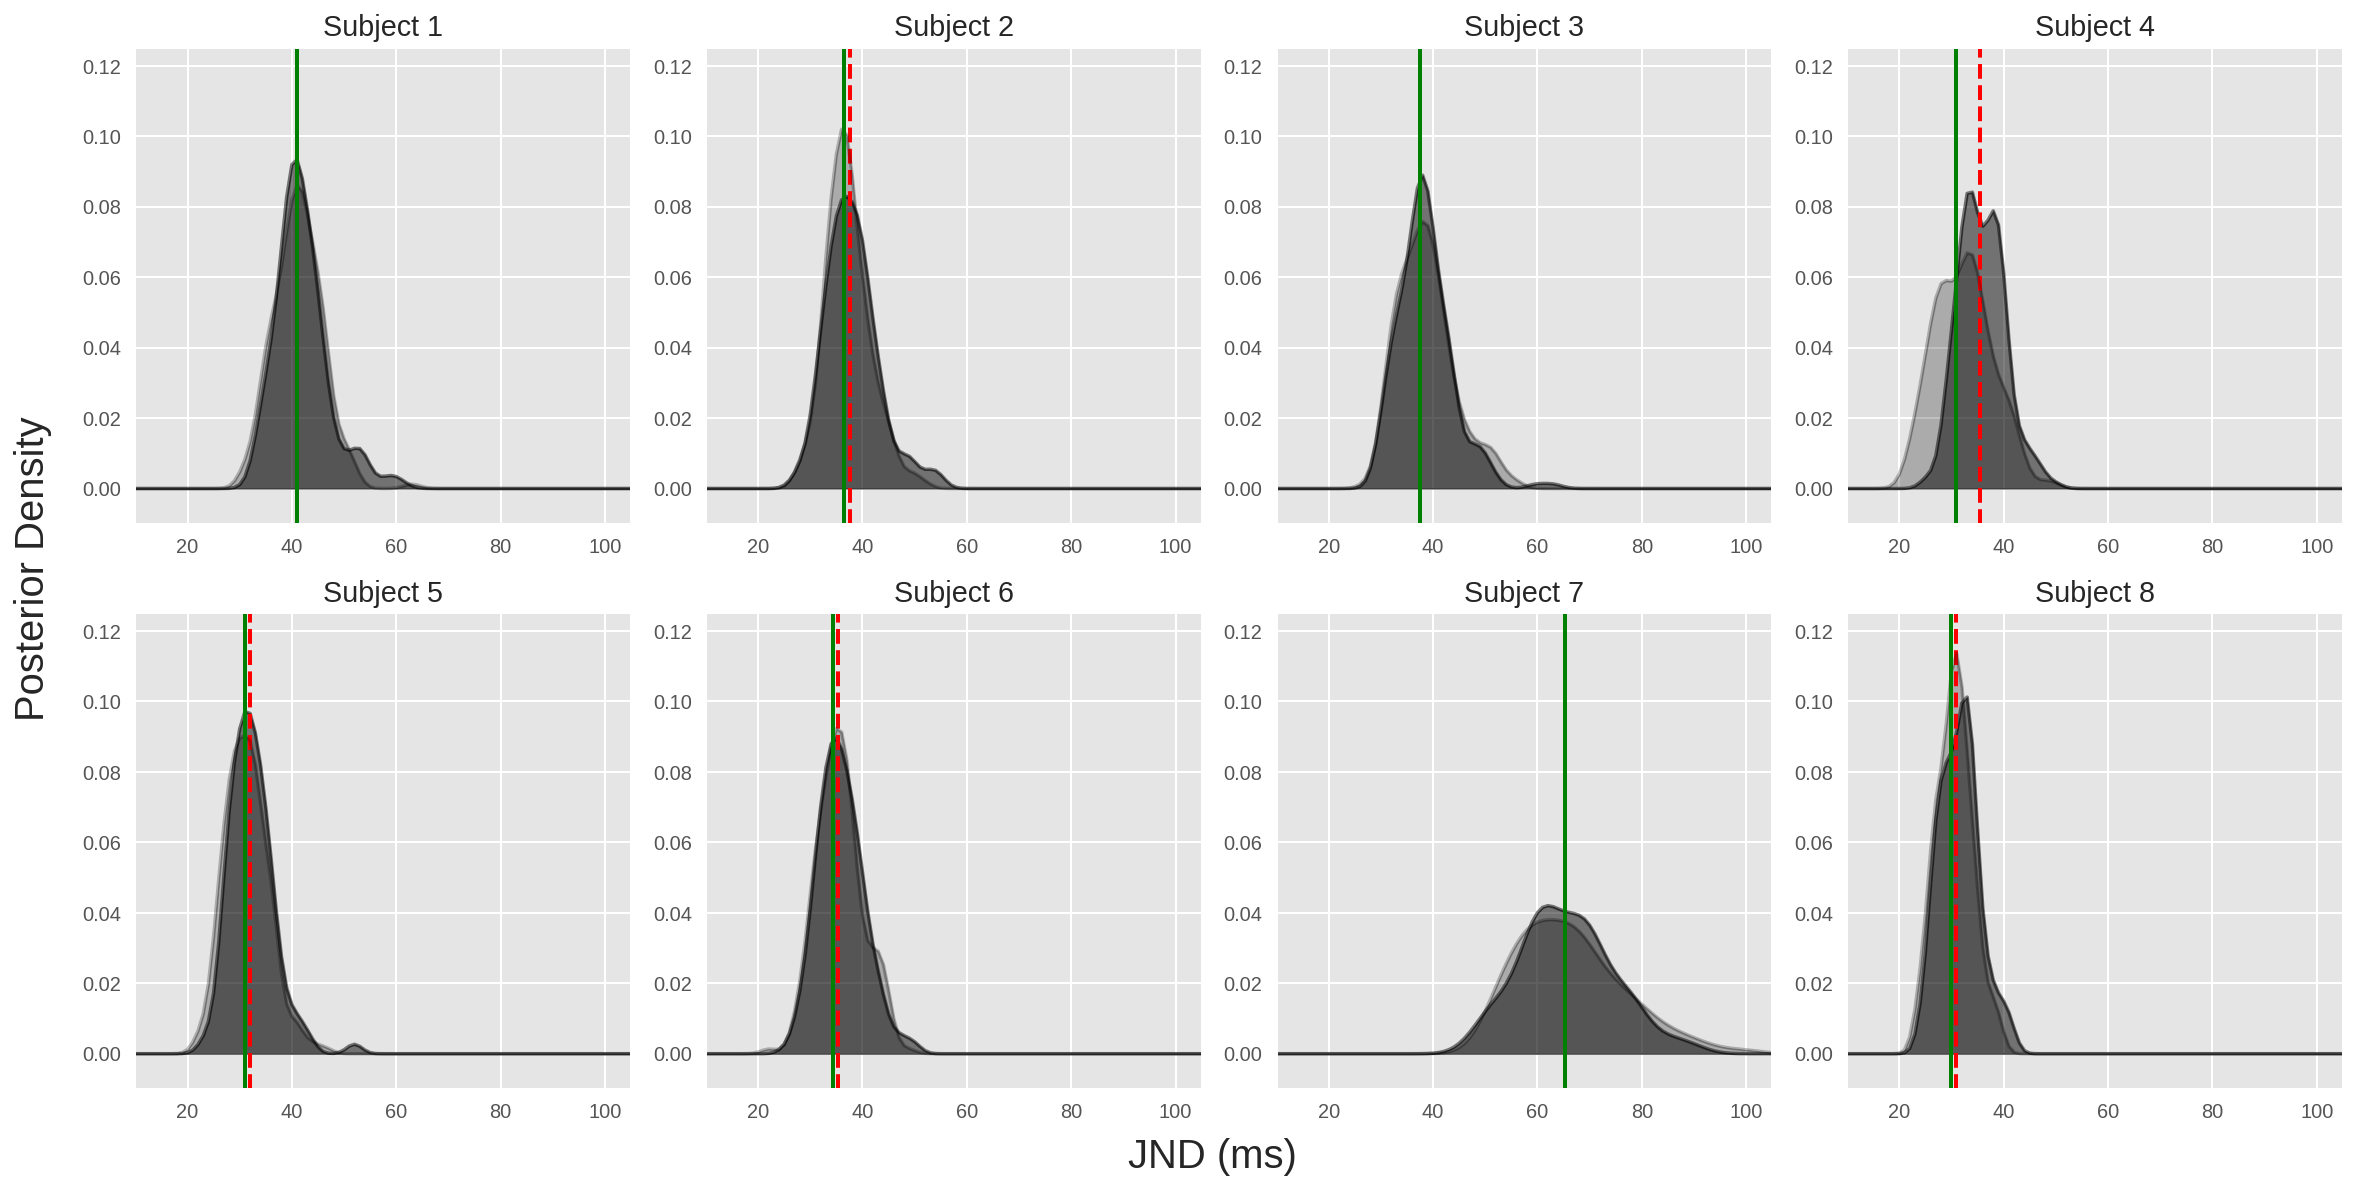

In [23]:
# reproduce figure 12.7
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'JND (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Posterior Density', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

ppcsamples=200

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    
    xl = np.linspace(190, 410, 200)
    
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]
    jnd1 = x2-x1
    
    yl2 = logit(alphaMAP2[ip] + betaMAP2[ip]*(xl-xmean[ip]))
    x12 = xl[find_nearest(yl2, .5)]
    x22 = xl[find_nearest(yl2, .84)]
    jnd2 = x22-x12
    
    # Posterior sample
    jndps=[]
    jndps2=[]
    for ips in np.random.randint(burnin, 3e3, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2, .5)]
        x2 = xl[find_nearest(yl2, .84)]
        jndps.append(x2-x1)
        
        param = trace2[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2, .5)]
        x2 = xl[find_nearest(yl2, .84)]
        jndps2.append(x2-x1)
        
    x2=np.linspace(10, 109, 100)
    
    pdfpc = gaussian_kde(jndps)
    plt.plot(x2, pdfpc(x2), 'k', alpha=.5) 
    plt.fill_between(x2, pdfpc(x2), 0, alpha=.5, color='k')
    plt.axvline(jnd1, color='r', ls='--', lw=2)
    
    pdfpc2 = gaussian_kde(jndps2)
    plt.plot(x2, pdfpc2(x2), 'k', alpha=.25) 
    plt.fill_between(x2, pdfpc2(x2), 0, alpha=.25, color='k')
    plt.axvline(jnd2, color='g', ls='-', lw=2)
    
    plt.axis([10, 105, -.01, .125])
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()